|<div style="width:330px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:330px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="300"/></div>|<div style="width:330px"><img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="300"/></div>|
|---|---|--:|

# McWhorter Problem
<cite>[McWhorter and Sunada][1]</cite> propose an analytical solution to the two-phase flow equation. A one-dimensional problem was considered which describes the flow of two incompressible, immiscible fluids through a porous medium, where the wetting phase (water) displaces the non-wetting fluid (air or oil) in the horizontal direction (without the influence of gravity).


![mcWhorter_concept_schematic.png](figures/mcWhorter_concept.png)

## Analytical solution


A detailed semi-analytical solution and a convenient tool for calculating the solution for different material parameters can be found [here](https://mmg.fjfi.cvut.cz/~fucik/index.php?page=exact).

### Material Parameters

| Property  | Symbol | Value | Unit |
|----------:|:------:|-------|------|
| Porosity | $\phi$ | 0.15 | 1 |
| Intrinsic permeability | $K$ | $$1.0\cdot 10^{-10}$$ | $m^2$|
| Residual saturation of the wetting phase | $$s_\mathrm{L}^{res}$$ | 0.02 | 1 |
| Residual saturation of the non-wetting phase | $$s_\mathrm{G}^{res}$$ | 0.001 | 1 |
| Dynamic viscosity of the wetting phase	|$\mu_\mathrm{L}$|$$1.0\cdot 10^{-3}$$|Pa s|
| Dynamic viscosity of the non-wetting pha  |$\mu_\mathrm{G}$  |$$5.0\cdot 10^{-3}$$|Pa s|
| Brooks and Corey model parameter: entry pressure | $p_b$ | 5000 | Pa |
| Brooks and Corey model parameter: pore size distribution index |$\lambda$ | 3.0 | 1 |

### Problem Parameters

| Property  | Symbol | Value | Unit |
|----------:|:------:|-------|------|
| Initial saturation | $$s_\mathrm{L}(t=0)$$ | 0.05 | 1 |
| Injection boundary saturation | $$s_\mathrm{L}(x=0)$$ | 0.8 | 1 |


[1]: https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/WR026i003p00399?casa_token=6yzGcmrd7dkAAAAA:E6QsKTxrf12GO-0CY6qgu4XEcX6iFM4O_mnaVV2gWBO8voVnxYXxLOtnAdUnBskEOPZiwaFAggWnmqpg

## Exact Solution

The exact solution is not yet calculated in this notebook, instead the [online tool](https://mmg.fjfi.cvut.cz/~fucik/index.php?page=exact) by Radek Fučík is used. This tool calculates the solution and outputs the results with arbitrary accuracy as CSV files, which are plotted below.

In [1]:
import numpy as np

# Import analytical solution from a CSV file
exact = np.loadtxt("data/ref_solution_saturation.csv", delimiter=",")
# Zeroth column is location, first column is saturation

## Numerical Solution

In [2]:
import os
from pathlib import Path

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [3]:
import ogstools as ogs

# run OGS
model = ogs.Project(input_file="mcWhorter_h2.prj", output_file="mcWhorter_h2.prj")
model.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir}")

OGS finished with project file mcWhorter_h2.prj.
Execution took 46.44939184188843 s


In [4]:
import vtuIO

# read OGS results from PVD file
pvdfile = vtuIO.PVDIO(
    f"{out_dir}/result_McWhorter_H2.pvd", dim=2, interpolation_backend="vtk"
)

In [5]:
import numpy as np

# The sampling routine requires a line of points in space
x_axis = [(i, 0, 0) for i in exact[:, 0]]

# Only the last timestep is written (together with the initial condition).
# Thus the second element of the time vector (index = 1) is the to be sampled
time = pvdfile.timesteps[1]

# The numerical solution is sampled at the same supporting points as the analytical solution
sL_num = pvdfile.read_set_data(time, "saturation", pointsetarray=x_axis)

# Absolute and relative errors
err_abs = exact[:, 1] - sL_num
err_rel = err_abs / exact[:, 1]

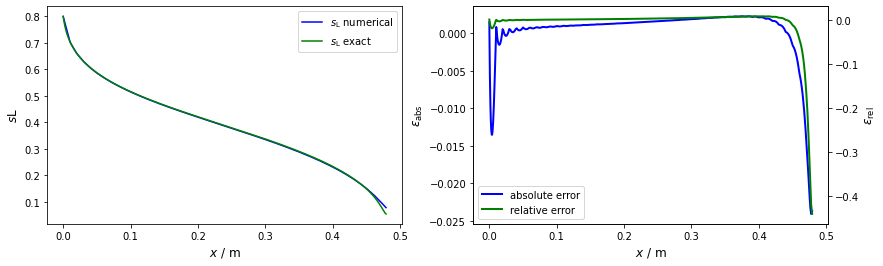

In [6]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 4)
fig1, (ax1, ax2) = plt.subplots(1, 2)

fig1.suptitle(r"Liquid saturation and errors at t=" + str(time) + " seconds")

# Saturation vs. time
ax1.set_xlabel("$x$ / m", fontsize=12)
ax1.set_ylabel(r"$s_\mathrm{L}$", fontsize=12)

ax1.plot(exact[:, 0], sL_num, "b", label=r"$s_\mathrm{L}$ numerical")
ax1.plot(exact[:, 0], exact[:, 1], "g", label=r"$s_\mathrm{L}$ exact")

lns2 = ax2.plot(
    exact[:, 0], err_abs, "b", linewidth=2, linestyle="-", label=r"absolute error"
)

ax2.set_xlabel("$x$ / m", fontsize=12)
ax2.set_ylabel(r"$\epsilon_\mathrm{abs}$", fontsize=12)

ax3 = ax2.twinx()
lns3 = ax3.plot(
    exact[:, 0], err_rel, "g", linewidth=2, linestyle="-", label=r"relative error"
)
ax3.set_ylabel(r"$\epsilon_\mathrm{rel}$", fontsize=12)

ax1.legend()

lns = lns2 + lns3
labs = [label.get_label() for label in lns]
ax2.legend(lns, labs, loc=0)


fig1.savefig(f"{out_dir}/mcWhorter.pdf")

The numerical approximation fits the analytical solution very well in the whole area. Only in the area of the saturation front are deviations recognisable. These deviations are mainly due to the grid resolution and are well known in multiphase simulations. The error can be reduced almost arbitrarily by lowering the size of the grid elements.